In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gum.about()
gnb.configuration()


pyAgrum version 0.9.2.9
(c) Pierre-Henri Wuillemin, Christophe Gonzales, Lionel Torti
    UPMC 2015

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,posix [linux]
Python,"3.5.0+ (default, Oct 11 2015, 09:05:38) [GCC 5.2.1 20151010]"
IPython,4.0.0
MatPlotLib,1.5.0
Numpy,1.10.1
pyAgrum,0.9.2.9


# Generating the database from a BN

In [26]:
bn=gum.loadBN("../resources/asia.bif")
gnb.showBN(bn)

In [27]:
# generateCSV from a BN : the loglikelihood of the base is returned
import pyAgrum.lib.bn2csv as bn2csv
bn2csv.generateCSV(bn,"sample_asia.csv",500000,True)

 sample_asia.csv : [ ######################################################### ] 100%
Log2-Likelihood : -1615599.1742011285



-1615599.1742011285

In [5]:
from pyAgrum.lib.utils.oslike import wc_l,head
print("===\n  Size of the generated database\n===")
wc_l("sample_asia.csv")
print("\n===\n  First lines\n===")
head("sample_asia.csv")

===
  Size of the generated database
===
500001

===
  First lines
===
smoking?,lung_cancer?,bronchitis?,visit_to_Asia?,tuberculosis?,tuberculos_or_cancer?,dyspnoea?,positive_XraY?
0,1,0,1,1,1,0,0
0,1,1,1,1,1,0,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
0,1,0,1,1,1,1,1
0,1,0,1,1,1,0,1
1,1,1,1,1,1,0,1



In [6]:
learner=gum.BNLearner("sample_asia.csv")
learner.names()

('smoking?',
 'lung_cancer?',
 'bronchitis?',
 'visit_to_Asia?',
 'tuberculosis?',
 'tuberculos_or_cancer?',
 'dyspnoea?',
 'positive_XraY?')

In [7]:
learner.idFromName('visit_to_Asia?') # first row is 0

3

In [8]:
learner.nameFromId(4)

'tuberculosis?'

# Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

In [9]:
learner=gum.BNLearner('sample_asia.csv',bn)
bn2=learner.learnParameters(bn)
gnb.showBN(bn2)

In [24]:
from pyAgrum.lib.pretty_print import pretty_cpt
from IPython.display import HTML

HTML('<table width="100%"><tr><td style="text-align:center;">original BN</td>'+
     '<td style="text-align:center;">Learned BN</td></tr>'+
     '<tr><td style="text-align:right;"><pre>'+
     pretty_cpt (bn.cpt (bn.idFromName('visit_to_Asia?')))
    +'</pre></td><td style="text-align:right;"><pre>'+
     pretty_cpt(bn2.cpt(bn2.idFromName('visit_to_Asia?')))
     +'</pre></td></tr><tr><td style="text-align:right;"><pre>'+
     pretty_cpt (bn.cpt (bn.idFromName('tuberculosis?')))
    +'</pre></td><td style="text-align:right;"><pre>'+
     pretty_cpt(bn2.cpt(bn2.idFromName('tuberculosis?')))
     +'</pre></td></tr></table>')

original BN,Learned BN
|---------------| |visit_to_Asia? | | 0 1 | |---------------| | 0.0100 0.9900 | |---------------|,|---------------| |visit_to_Asia? | | 1 0 | |---------------| | 0.9899 0.0101 | |---------------|
|---------------| ----------------| tuberculosis? | visit_to_Asia? | 0 1 | ----------------|---------------| 0 | 0.0500 0.9500 | 1 | 0.0100 0.9900 | ----------------|---------------|,|---------------| ----------------| tuberculosis? | visit_to_Asia? | 1 0 | ----------------|---------------| 1 | 0.9901 0.0099 | 0 | 0.9499 0.0501 | ----------------|---------------|


# Structural learning a BN from the database

## Different algorithms

For now, there are three algorithms that are wrapped in pyAgrum : LocalSearchWithTabuList,

In [11]:
learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(bn2)
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

Learned in 3.333524s


{'bhattacharya': 5.493847622527333,
 'errorPQ': 0,
 'errorQP': 128,
 'hellinger': 1.4113029791211433,
 'klPQ': 21.83553788805645,
 'klQP': 20.174939573983675}

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [12]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(bn2)

Learned in 0.502448s


And a K2 for those who likes it :)

In [13]:
learner=gum.BNLearner("sample_asia.csv")
learner.useK2([0,1,2,3,4,5,6,7])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(bn2)

Learned in 0.272495s


K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [14]:
learner=gum.BNLearner("sample_asia.csv")
learner.useK2([7,6,5,4,3,2,1,0])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.showBN(bn2)

Learned in 0.407861s


# Following the learning curve

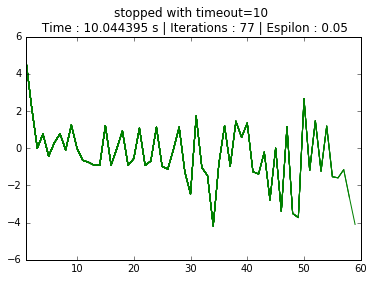

In [15]:
learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 1 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


# Customizing the learning algorithms

## 1. Learn a tree ?

In [16]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")

## 2. with prior structural knowledge

In [17]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1) # smoking->lung_cancer
learner.addMandatoryArc("visit_to_Asia?","tuberculosis?")

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

{'bhattacharya': 5.590267167359873,
 'errorPQ': 0,
 'errorQP': 128,
 'hellinger': 1.411570746096023,
 'klPQ': 22.501716722173146,
 'klQP': 20.174341281195876}

## 3. changing the scores

By default, a BDEU score is used. But it can be changed.

In [18]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

{'bhattacharya': 4.494522638036479,
 'errorPQ': 64,
 'errorQP': 96,
 'hellinger': 1.4062929757494587,
 'klPQ': 15.760210603820498,
 'klQP': 20.138069193883556}

## 4. Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [19]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
gnb.showBN(bn2)

And then we refine with tabuList

In [21]:
learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()

#learner.setInitialDAG(bn2.dag())
##learner.setMaxNbDecreasingChanges(2)

bn3=learner.learnBN()
gnb.showBN(bn3)
kl=gum.BruteForceKL(bn,bn3)
kl.compute()

{'bhattacharya': 5.493847622527333,
 'errorPQ': 0,
 'errorQP': 128,
 'hellinger': 1.4113029791211433,
 'klPQ': 21.83553788805645,
 'klQP': 20.174939573983675}

# Impact of the size of the database for the learning

In [22]:
import IPython.display
rows=3
sizes=[300,400,500,700,1000,2000,5000,
       10000,20000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

In [29]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    !head -n $n sample_asia.csv > extract_asia.csv
    !wc extract_asia.csv
    learner=gum.BNLearner("extract_asia.csv")
    learner.useGreedyHillClimbing()
    bn2=learner.learnBN()
    !rm -f extract_asia.csv
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3").data+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])

head: sample_asia.csv: nombre de lignes incorrect
0 0 0 extract_asia.csv


Exception: Null Element : No parsed data

In [25]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    !head -n $n sample_asia.csv > extract_asia.csv
    #!wc extract_asia.csv
    learner=gum.BNLearner("extract_asia.csv")
    learner.useLocalSearchWithTabuList()
    bn2=learner.learnBN()
    !rm -f extract_asia.csv
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    bn2.setProperty("name","BN(%{0})".format(i))
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3").data+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])

head: sample_asia.csv: nombre de lignes incorrect


Exception: Null Element : No parsed data